<a href="https://colab.research.google.com/github/JsteReubsSoftware/COS791-Assignment1/blob/main/u21457060_COS791_A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
This is the first assignment of COS 791: Image Processing.

Student: Reuben Jooste (u21457060)

# Library Imports and Installations

In [1]:
!pip install opencv-contrib-python

In [2]:
import csv
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import pandas as pd
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio, structural_similarity
from skimage.feature import match_descriptors
from google.colab.patches import cv2_imshow
from skimage import filters

# Data Loading and Analysis

In [81]:
# load dataset from storage location
path = '/content/drive/MyDrive/University/Honours/COS791/Assignments/A1/Cos791-A1-Dataset'
# list files in directory
image_files = os.listdir(path)

# sort the images according to their image number that appears after 'Img' and before '.png'
image_files.sort(key=lambda x: int(x[3:-4]))
image_files

['Img0.png',
 'Img1.png',
 'Img2.png',
 'Img3.png',
 'Img4.png',
 'Img5.png',
 'Img6.png',
 'Img7.png',
 'Img8.png',
 'Img9.png',
 'Img10.png']

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


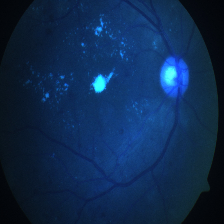

In [82]:
# View image sizes
images = []
for image in image_files:
  img = cv2.imread(os.path.join(path, image))
  images.append(image)
  print(img.shape)

# show first image
cv2_imshow(cv2.cvtColor(cv2.imread(os.path.join(path, images[0])), cv2.COLOR_BGR2RGB))

### Preprocess data to make it Grayscaled Images

(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)


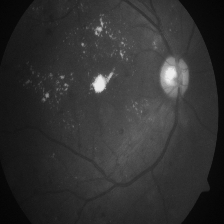

In [83]:
gray_images = []
for image in images:
  img = cv2.imread(os.path.join(path, image), cv2.IMREAD_GRAYSCALE)
  # gray_images.append(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))
  gray_images.append(img)
  print(gray_images[-1].shape)

# show first image
cv2_imshow(gray_images[0])

In [84]:
def create_gabor_filters(num_filters=32, ksize=3, sigma=3.0, lambd=10.0, gamma=0.5, psi=0):
    # Params:
    #     num_filters: Number of filters to create.
    #     ksize: Kernel size.
    #     sigma: Standard deviation of the Gaussian envelope.
    #     lambd: Wavelength of the sinusoidal factor.
    #     gamma: Aspect ratio of the Gaussian envelope.
    #     psi: Phase offset.

    filters = []
    for theta in np.linspace(0, np.pi, num_filters, endpoint=False):
        kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lambd, gamma, psi)
        kernel /= kernel.sum()  # Normalize kernel
        filters.append(kernel)
    return filters

def apply_gabor_filters(image, filters):
    filtered_image = np.zeros_like(image)
    for kernel in filters:
        filtered_image = np.maximum(filtered_image, cv2.filter2D(image, -1, kernel))
    return filtered_image

# Create and apply Gabor filters
filters = create_gabor_filters()
images = [apply_gabor_filters(image, filters) for image in gray_images]
gray_images = images

### Generate Reference Images using Canny Library

Image 1


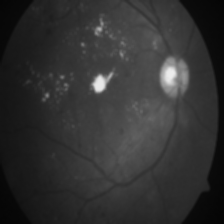

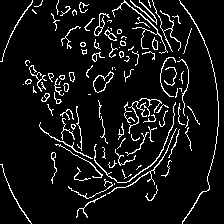

Image 2


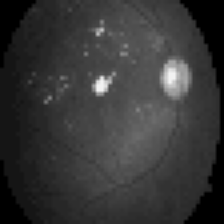

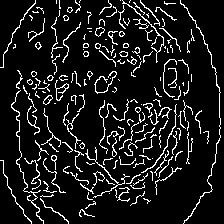

Image 3


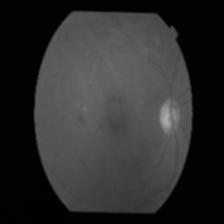

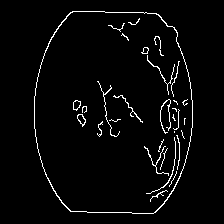

Image 4


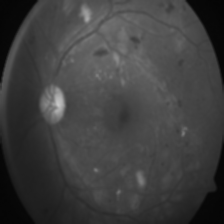

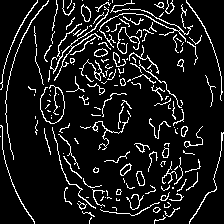

Image 5


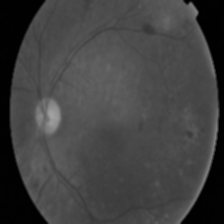

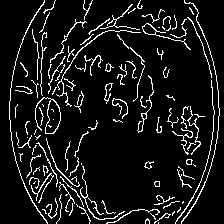

Image 6


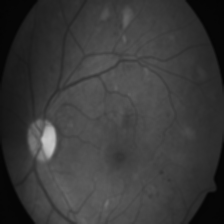

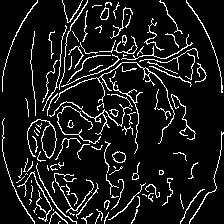

Image 7


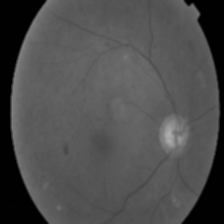

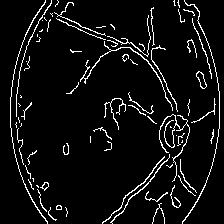

Image 8


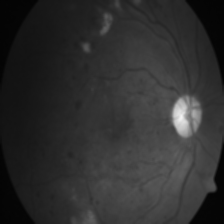

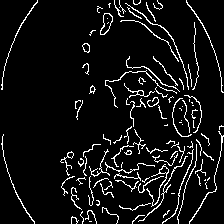

Image 9


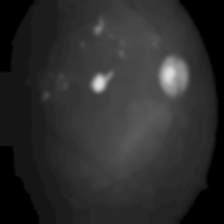

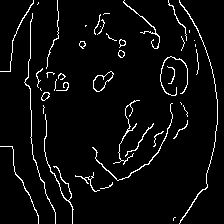

Image 10


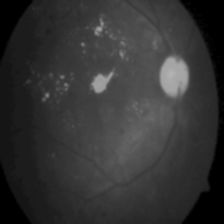

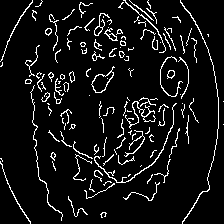

Image 11


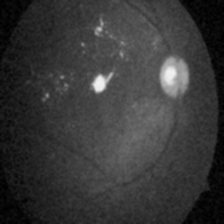

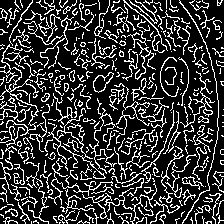

Image 1
(224, 224)
Image 2
(224, 224)
Image 3
(224, 224)
Image 4
(224, 224)
Image 5
(224, 224)
Image 6
(224, 224)
Image 7
(224, 224)
Image 8
(224, 224)
Image 9
(224, 224)
Image 10
(224, 224)
Image 11
(224, 224)


In [85]:
canny_ref_imgs = []
# Defining all the parameters
t_lower = 100 # Lower Threshold
t_upper = 200 # Upper threshold
aperture_size = 5 # Aperture size
L2Gradient = True # Boolean

for i, img in enumerate(gray_images):
    blurred_image = cv2.GaussianBlur(img, (5, 5), 1.4)
    # Apply Canny edge detector
    edges = cv2.Canny(blurred_image, t_lower, t_upper, apertureSize = aperture_size, L2gradient = L2Gradient)
    # edges = cv2.Canny(img, t_lower, t_upper, apertureSize = aperture_size, L2gradient = L2Gradient )
    canny_ref_imgs.append(edges)
    print(f'Image {i+1}')
    cv2_imshow(img)
    cv2_imshow(edges)

# print shape of images
for i, img in enumerate(canny_ref_imgs):
  print(f'Image {i+1}')
  print(img.shape)

# Pipeline Framework
All images appear to have the same size and has colour. We now need to build a pipeline framework which we can use to apply all the components of edge detection to a single image.

Our proposed framework will consist of the following integral components (steps):

1. Noise Reduction:
- Objective: To diminish the influence of noise, which may obstruct the process of edge detection.
- Options: Gaussian blurring, median filtering, and bilateral filtering.

2. Gradient Calculation:
- Objective: To ascertain the rate of variation in pixel intensity across both horizontal and vertical orientations.
- Options: Sobel, Prewitt, or Laplacian operators are frequently utilized.

3. Edge Thinning (Non-Maximum Suppression):
- Objective: To enhance the detected edges to a singular pixel width.
- Options: By evaluating the gradient magnitude of a pixel in relation to its neighboring pixels, those that do not represent local maxima in the gradient direction are eliminated.

4. Thresholding:
- Objective: To distinguish between genuine edges and noise artifacts.
- Options: Hysteresis thresholding and binary thresholding.

5. Edge Linking:
- Objective: To unify disjointed edge segments.
- Options: Hough transform, gradient direction analysis, and region growing.

# Our Approach
We will make use of a Genetic Algorithm to help find and build an optimal pipeline.

## Chromosome Representation
- Each chromosome will represent a pipeline configuration.
- The genes of each chromosome will comprise of the unique parameters required for the different components of edge detection (see above Pipeline Framework)

## Initial Population Generation
Our algorithm will start by randomly generating unique configurations.
The are the following options for each Gene:
- Gene 1 (Noise reduction):
  - method: 'gaussian', 'median', 'bilateral'
  - params:
      - ksize: (3, 3), (5, 5)
      - sigma: random.uniform(0.5, 2.0)
- Gene 2 (Gradient):
  - method: 'sobel', 'prewitt', 'laplacian'
  - params:
    - ksize: 3, 5
- Gene 3 (Thinning):
  - method: True or False
- Gene 4 (Thresholding):
  - method: 'binary' or 'hysteresis'
  - params:
    - low: random integer in range 30-100
    - high: random integer in range 150-255
- Gene 5 (Linking):
  - method: 'hough', ;region_growing'
  - params:
    - threshold: random integer in range 50-150

*Example Representation*:
```
chromosome = {
            'noise_reduction': {
              'method': 'gaussian',
              'params': {
                'ksize': (3, 3),
                'sigma': random.uniform(0.5, 2.0)
              },
            },
            'gradient': {
              'method': 'laplacian',
              'params': {
                'ksize': 5
              },
            },
            'thinning': True,
            'thresholding': {
              'method': 'hysteresis',
              'params': {
                'low': 35,
                'high': 200
              },
            },
            'linking': {
              'method': 'hough',
              'params': {
                'threshold': 75
              }
            }
        }
```
## Genetic Operators
We will make use of the two common operators: Crossover and Mutation
- Crossover:
  This will involve swapping the genes between two parents to create two offsprings
- Mutation:
  This will involve make some random change to a randomly selected gene

## Selection:
We will use Tournament Selection to select two best parents from a tournament pool.

## Fitness Function:
Our fitness function will simply calculate how well a pipeline performs on an image. We can use metrics like:
- feature descriptor (ORB/SIFT)
- mean-square-error(MSE)
- peak-signal-noise-ratio
- structural-similarity

## GA parameters:
- population size
- generations
- crossover rate
- mutation rate
- tournament size

# Main Program

In [86]:
# define possible values for pipeline configuration
noise_reduction_methods = ['gaussian', 'median', 'bilateral']
noise_reduction_ksizes = [(3, 3), (5, 5)]
gaussian_sigmas_range = [0.5, 1.25]
# if we use bilateral we have the following params ranges
bilateral_d_range = [v for v in range(5,26)]
bilateral_sigma_space_range = [1, 100]
bilateral_sigma_color_range = [1, 100]
gradient_methods = ['sobel', 'prewitt', 'laplacian']
gradient_ksizes = [3, 5]
thresholding_methods = ['binary', 'hysteresis']
thresholding_low_high_range = [v for v in range(10, 130, 10)]
thresholding_high_range = [v for v in range(150, 256, 10)]
linking = ['gradient_direction_analysis', 'region_growing']
linking_thresholding_range = [v for v in range(5, 20)]

### Initial Population Generation

In [87]:
# def function to build configuration for each component
def set_noise_reduction(chromosome):
  if chromosome['noise_reduction']['method'] == 'gaussian':
      k_arrSize = len(noise_reduction_ksizes)
      chromosome['noise_reduction']['params']['ksize'] = noise_reduction_ksizes[random.randint(k_arrSize)]
      chromosome['noise_reduction']['params']['sigma'] = random.uniform(gaussian_sigmas_range[0], gaussian_sigmas_range[1])
  elif chromosome['noise_reduction']['method'] == 'median':
      k_arrSize = len(noise_reduction_ksizes)
      chromosome['noise_reduction']['params']['ksize'] = noise_reduction_ksizes[random.randint(k_arrSize)]
  elif chromosome['noise_reduction']['method'] == 'bilateral':
      chromosome['noise_reduction']['params']['d'] = random.choice(bilateral_d_range)
      chromosome['noise_reduction']['params']['sigma_color'] = random.uniform(bilateral_sigma_color_range[0], bilateral_sigma_color_range[1])
      chromosome['noise_reduction']['params']['sigma_space'] = random.uniform(bilateral_sigma_space_range[0], bilateral_sigma_space_range[1])

  return chromosome

def set_gradient(chromosome):
    chromosome['gradient']['method'] = random.choice(gradient_methods)
    chromosome['gradient']['params']['ksize'] = random.choice(gradient_ksizes)
    chromosome['gradient']['params']['ddepth'] = -1
    return chromosome

def set_thresholding(chromosome):
    chromosome['thresholding']['params']['low'] = random.choice(thresholding_low_high_range)
    chromosome['thresholding']['params']['high'] = random.choice(thresholding_high_range)
    chromosome['thresholding']['params']['threshold_type'] = cv2.THRESH_BINARY
    chromosome['thresholding']['params']['max_value'] = 255

    return chromosome

def set_linking(chromosome):
    chromosome['linking']['params']['threshold'] = random.choice(linking_thresholding_range)
    chromosome['linking']['params']['seed_points'] = []
    return chromosome

In [88]:
# define function to generate population
def generate_population(pop_size):
  population = []
  for i in range(pop_size):
    chromosome = {
        "noise_reduction": {
            "method": None,
            "params": {}
        },
        "gradient": {
            "method": None,
            "params": {}
        },
        "thinning": True, # we will apply thinning: Non-max Suppression
        "thresholding": {
            "method": None,
            "params": {}
        },
        "linking": {
            "method": None,
            "params": {}
        }
    }
    # Step 1 is to apply noise reduction
    chromosome['noise_reduction']['method'] = random.choice(noise_reduction_methods)
    chromosome = set_noise_reduction(chromosome)

    # Step 2 is to apply Gradient
    chromosome = set_gradient(chromosome)

    # Step 3 is to apply thinning
    chromosome['thinning'] = True # we will apply the Non-Max suppression algo.

    # Step 4 is to apply thresholding
    chromosome['thresholding']['method'] = random.choice(thresholding_methods)
    chromosome = set_thresholding(chromosome)

    # Step 5 is to apply linking
    chromosome['linking']['method'] = random.choice(linking)
    chromosome = set_linking(chromosome)

    population.append(chromosome)
  return population


### Helper Functions

In [89]:
def apply_hysteresis(image, weak_pixel, strong_pixel=255):
    rows, cols = image.shape

    # retrieve strong and weak edges
    strong = image > strong_pixel
    weak = (image >= weak_pixel) & (image <= strong_pixel)
    threshold_img = np.zeros_like(image)
    threshold_img[strong] = strong_pixel
    threshold_img[weak] = weak_pixel

    # Iterate over the image excluding the borders
    for row in range(1, rows-1):
        for col in range(1, cols-1):
            if image[row, col] == weak_pixel:
                # Check if any of the neighboring pixels is strong
                neighbors = [
                    image[row+1, col-1], image[row+1, col], image[row+1, col+1],
                    image[row, col-1], image[row, col+1],
                    image[row-1, col-1], image[row-1, col], image[row-1, col+1]
                ]
                # Update weak pixel to strong if connected to a strong pixel
                if strong_pixel in neighbors:
                    image[row, col] = strong_pixel
                else:
                    image[row, col] = 0
    return image

In [90]:
def threshold(img, low, high, lowThresholdRatio=0.05, highThresholdRatio=0.09):
    # Compute the high and low thresholds based on the maximum intensity of the image
    highThreshold = img.max() * highThresholdRatio
    lowThreshold = highThreshold * lowThresholdRatio

    # Define the weak and strong edge pixel values
    weak, strong = 25, 255

    # Initialize the result array with zeros (same shape as the input image)
    res = np.zeros_like(img, dtype=np.int32)

    # Identify the indices for strong and weak edges
    strong_mask = img >= highThreshold
    weak_mask = (img >= lowThreshold) & (img < highThreshold)

    # Assign the strong and weak edge values to the result array
    res[strong_mask] = strong
    res[weak_mask] = weak

    return res

In [91]:
def apply_non_max_suppression(gradient_magnitude, gradient_direction):
    rows, cols = gradient_magnitude.shape
    suppressed_image = np.zeros((rows, cols))

    # Convert gradient directions from radians to degrees
    angles = gradient_direction * 180.0 / np.pi
    angles[angles < 0] += 180
    angles %= 180  # Ensure angles are in [0, 180)

    for row in range(1, rows-1):
        for col in range(1, cols-1):
            # Initialize placeholders for neighboring pixels
            neighbor1, neighbor2 = 255, 255

            angle = angles[row, col]

            # Angle 0 degrees (horizontal edges)
            if (0 <= angle < 22.5) or (157.5 <= angle <= 180):
                neighbor1 = gradient_magnitude[row, col+1]
                neighbor2 = gradient_magnitude[row, col-1]
            # Angle 45 degrees (diagonal edges)
            elif (22.5 <= angle < 67.5):
                neighbor1 = gradient_magnitude[row+1, col-1]
                neighbor2 = gradient_magnitude[row-1, col+1]
            # Angle 90 degrees (vertical edges)
            elif (67.5 <= angle < 112.5):
                neighbor1 = gradient_magnitude[row+1, col]
                neighbor2 = gradient_magnitude[row-1, col]
            # Angle 135 degrees (anti-diagonal edges)
            elif (112.5 <= angle < 157.5):
                neighbor1 = gradient_magnitude[row-1, col-1]
                neighbor2 = gradient_magnitude[row+1, col+1]

            # Suppress non-maximum pixels
            if (gradient_magnitude[row, col] >= neighbor1) and (gradient_magnitude[row, col] >= neighbor2):
                suppressed_image[row, col] = gradient_magnitude[row, col]
            else:
                suppressed_image[row, col] = 0

    return suppressed_image

In [92]:
def region_growing(threshold_edges, seed_points, threshold=10):
    rows, cols = threshold_edges.shape
    visited = np.zeros((rows, cols), dtype=bool)
    linked_edges = np.zeros_like(threshold_edges)

    def is_valid(x, y):
        # Check if pixel (x, y) is within the image bounds
        return 0 <= x < threshold_edges.shape[0] and 0 <= y < threshold_edges.shape[1]

    # normalize
    threshold_edges = threshold_edges.astype(np.float32) / 255

    # Initialize a stack with the seed points
    queue = list(seed_points)

    while queue:
      x, y = queue.pop(0)

      # Check if the pixel has already been visited
      if linked_edges[x, y] == 0:
          visited[x, y] = True  # Mark pixel as visited
          linked_edges[x, y] = 1  # Mark as part of the edge

          # Check the 8 neighbors
          for dx, dy in [(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1)]:
              nx, ny = x + dx, y + dy
              if is_valid(nx, ny) and np.linalg.norm(threshold_edges[nx, ny] - threshold_edges[x, y]) <= threshold:
                  queue.append((nx, ny))

    return linked_edges


In [93]:
def apply_prewitt(gray_img):
    h, w = gray_img.shape

    # Define filters
    horizontal_filter = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])  # s2
    vertical_filter = np.array([[-1, -1, -1], [0, 0, 0], [1, 1, 1]])    # s1

    # Initialize gradient magnitude and direction arrays with zeros
    gradient_magnitude = np.zeros((h, w))
    gradient_direction = np.zeros((h, w))

    # Compute gradients with offset
    for i in range(1, h - 1):
        for j in range(1, w - 1):
            horizontal_grad = np.sum(horizontal_filter * gray_img[i-1:i+2, j-1:j+2])
            vertical_grad = np.sum(vertical_filter * gray_img[i-1:i+2, j-1:j+2])

            # Calculate the magnitude of the gradient
            magnitude = np.sqrt(horizontal_grad**2 + vertical_grad**2)
            gradient_magnitude[i - 1, j - 1] = magnitude

            # Calculate the direction (angle) of the gradient in radians
            direction = np.arctan2(vertical_grad, horizontal_grad)
            gradient_direction[i - 1, j - 1] = direction

    return gradient_magnitude, gradient_direction

In [94]:
def apply_gradient_directional_analysis(thresholded_edges, gradient_magnitude, gradient_direction):
    rows, cols = thresholded_edges.shape
    linked_edges = np.zeros((rows, cols), dtype=np.uint8)

    # Convert gradient directions from radians to degrees
    angles = gradient_direction * 180.0 / np.pi
    angles[angles < 0] += 180
    angles %= 180  # Ensure angles are in [0, 180)

    # Define a linking threshold for gradient direction similarity
    direction_threshold = 22.5

    for row in range(1, rows-1):
        for col in range(1, cols-1):
            if thresholded_edges[row, col] > 0:  # If the pixel is an edge pixel
                angle = angles[row, col]

                # Initialize linked status as false
                linked = False

                # Check the 8-connected neighbors
                for dx, dy in [(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1)]:
                    neighbor_row, neighbor_col = row + dx, col + dy

                    # Ensure the neighbor is within bounds
                    if 0 <= neighbor_row < rows and 0 <= neighbor_col < cols:
                        neighbor_angle = angles[neighbor_row, neighbor_col]

                        # Check if the neighbor pixel is an edge pixel and if their gradient directions are similar
                        if thresholded_edges[neighbor_row, neighbor_col] > 0 and abs(angle - neighbor_angle) < direction_threshold:
                            linked = True
                            break

                if linked:
                    linked_edges[row, col] = 255  # Mark as linked edge pixel

    return linked_edges

In [95]:
def apply_edge_detection_pipeline(image, noise_reduction, gradient, thinning, thresholding, linking):
    # Step 1: Noise Reduction
    if noise_reduction['method'] == 'gaussian':
        noise_reduction_img = cv2.GaussianBlur(image, noise_reduction['params']['ksize'], sigmaX=noise_reduction['params']['sigma'], sigmaY=noise_reduction['params']['sigma'])
    elif noise_reduction['method'] == 'median':
        noise_reduction_img = cv2.medianBlur(image, noise_reduction['params']['ksize'][0])
    elif noise_reduction['method'] == 'bilateral':
        noise_reduction_img = cv2.bilateralFilter(image, noise_reduction['params']['d'], noise_reduction['params']['sigma_color'], noise_reduction['params']['sigma_space'])

    print('After noise reduction')
    cv2_imshow(noise_reduction_img)

    # Step 2: Gradient Calculation
    if gradient['method'] == 'sobel':
        grad_x = cv2.Sobel(noise_reduction_img, gradient['params']['ddepth'], 1, 0, ksize=gradient['params']['ksize'])
        grad_y = cv2.Sobel(noise_reduction_img, gradient['params']['ddepth'], 0, 1, ksize=gradient['params']['ksize'])
        gradient_magnitude = np.sqrt(grad_x**2 + grad_y**2)
        gradient_directions = np.arctan2(grad_y, grad_x)

    elif gradient['method'] == 'prewitt':
        # kernel_x = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])
        # kernel_y = np.array([[-1, -1, -1], [0, 0, 0], [1, 1, 1]])
        # grad_x = cv2.filter2D(noise_reduction_img, gradient['params']['ddepth'], kernel_x)
        # grad_y = cv2.filter2D(noise_reduction_img, gradient['params']['ddepth'], kernel_y)
        # gradient_magnitude = np.sqrt(grad_x**2 + grad_y**2)
        # gradient_directions = np.arctan2(grad_y, grad_x)
        gradient_magnitude,  gradient_directions = apply_prewitt(noise_reduction_img)

    elif gradient['method'] == 'laplacian':
        gradient_magnitude = cv2.Laplacian(noise_reduction_img, gradient['params']['ddepth'], ksize=gradient['params']['ksize'])
        gradient_directions = np.zeros_like(gradient_magnitude)

    print('After gradient calculation')
    cv2_imshow(gradient_magnitude)

    # Step 3: Edge Thinning (Non-Maximum Suppression)
    if gradient['method'] != 'laplacian':
      thinned_edges = apply_non_max_suppression(gradient_magnitude, gradient_directions)
    else:
      thinned_edges = gradient_magnitude

    # Step 2: Gradient Calculation
    # if gradient['method'] == 'sobel':
    #     grad_x = cv2.Sobel(image, gradient['params']['ddepth'], 1, 0, ksize=gradient['params']['ksize'])
    #     grad_y = cv2.Sobel(image, gradient['params']['ddepth'], 0, 1, ksize=gradient['params']['ksize'])
    #     gradient_magnitude = np.sqrt(grad_x**2 + grad_y**2)
    #     gradient_directions = np.arctan2(grad_y, grad_x)

    # elif gradient['method'] == 'prewitt':
    #     kernel_x = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])
    #     kernel_y = np.array([[-1, -1, -1], [0, 0, 0], [1, 1, 1]])
    #     grad_x = cv2.filter2D(image, gradient['params']['ddepth'], kernel_x)
    #     grad_y = cv2.filter2D(image, gradient['params']['ddepth'], kernel_y)
    #     gradient_magnitude = np.sqrt(grad_x**2 + grad_y**2)
    #     gradient_directions = np.arctan2(grad_y, grad_x)
    #     # gradient_magnitude, gradient_directions = apply_prewitt(image)

    # if gradient['params']['do_laplacian'] == True:
    #   # Apply Laplacian for edge enhancement
    #   laplacian_edges = cv2.Laplacian(image, gradient['params']['ddepth'], ksize=gradient['params']['ksize'])

    #   # Combine Sobel/Prewitt gradient magnitude with Laplacian edges
    #   gradient_magnitude = gradient_magnitude + laplacian_edges

    # # Normalize the combined result for visualization
    # # combined_magnitude = cv2.normalize(combined_magnitude, None, 0, 255, cv2.NORM_MINMAX)

    # print('After gradient calculation and Laplacian combination')
    # cv2_imshow(gradient_magnitude)

    # # Step 3: Edge Thinning (Non-Maximum Suppression)
    # thinned_edges = apply_non_max_suppression(gradient_magnitude, gradient_directions)

    print('After thinning')
    cv2_imshow(thinned_edges)

    # Ensure thinned_edges is single-channel and of type np.uint8
    if thinned_edges.ndim != 2:
        raise ValueError("Inside 'apply_edge_detection_pipeline' method: thinned_edges must be a single-channel image.")
    if thinned_edges.dtype != np.uint8:
        thinned_edges = np.uint8(thinned_edges)

    # Step 4: Thresholding
    if thresholding['method'] == 'binary':
        _, threshold_edges = cv2.threshold(thinned_edges, thresholding['params']['low'], 255, cv2.THRESH_BINARY)
    elif thresholding['method'] == 'hysteresis':
        # if gradient['method'] == 'laplacian':
        #     # Normalize the Laplacian result to 0-255
        #     thinned_edges = cv2.normalize(thinned_edges, None, 0, 255, cv2.NORM_MINMAX)

        #     # Convert the image to uint8 for thresholding
        #     thinned_edges = np.uint8(thinned_edges)
        # thinned_edges = threshold(thinned_edges, thresholding['params']['low'], thresholding['params']['high'])
        threshold_edges = apply_hysteresis(thinned_edges, thresholding['params']['low'], thresholding['params']['high'])
        # threshold_edges = threshold_edges.astype(np.uint8) * 255


    print('After thresholding')
    cv2_imshow(threshold_edges)

    # convert threshold edges
    if threshold_edges.dtype != np.uint8:
        threshold_edges = np.uint8(threshold_edges)

    # Step 5: Edge Linking
    if linking['method'] == 'gradient_direction_analysis' and gradient['method'] != 'laplacian':
        # perform GDA
        linked_edges = apply_gradient_directional_analysis(threshold_edges, gradient_magnitude, gradient_directions)
        output_img = np.zeros_like(threshold_edges)
        output_img[linked_edges > 0] = 255
    else:
        # linking['method'] == 'region_growing'
        # linking['params']['seed_points'] = np.argwhere(threshold_edges == 255)
        # linked_edges = region_growing(threshold_edges, linking['params']['seed_points'])
        edges = np.where(threshold_edges > 0)
        num_seed_points = 5
        # Ensure there are enough edge pixels to choose from
        if len(edges[0]) >= num_seed_points:
            seed_indexes = random.choices(range(len(edges[0])), k=num_seed_points)
        else:
            seed_indexes = range(len(edges[0]))  # Use all edge points if less than num_seed_points
        # Extract the seed points
        linking['params']['seed_points'] = [(edges[0][i], edges[1][i]) for i in seed_indexes]  # Use list comprehension for indexing
        linked_edges = region_growing(threshold_edges, linking['params']['seed_points'], linking['params']['threshold'])

        output_img = np.zeros_like(threshold_edges)
        output_img[linked_edges > 0] = 255

    print('After linking')
    cv2_imshow(output_img)

    return output_img


### Fitness Function

In [110]:
def calculate_metrics(reference_image, edges):
  # Calculate mean squared error
  mse = mean_squared_error(reference_image, edges)

  # Calculate structural similarity
  ssim = structural_similarity(reference_image, edges, full=True)
  structural_similarity_value = ssim[0]

  # Calculate peak signal noise ratio
  psnr = peak_signal_noise_ratio(reference_image, edges)

  # Calculate feature descriptor similarity (SIFT)
  sift = cv2.SIFT_create()
  kp1, des1 = sift.detectAndCompute(reference_image, None)
  kp2, des2 = sift.detectAndCompute(edges, None)

  # Handle case where no keypoints are detected
  if des1 is None or des2 is None or len(kp1) == 0 or len(kp2) == 0:
      sift_sim_score = 0  # Assign a default value for no matches
      return mse, psnr, structural_similarity_value, sift_sim_score

  # Match descriptors
  matches = match_descriptors(des1, des2, cross_check=True)

  # Calculate feature descriptor similarity (e.g., ratio test)
  sift_sim_score = len(matches) / min(len(kp1), len(kp2))

  return mse, psnr, structural_similarity_value, sift_sim_score

In [105]:
def fitness_function(pipeline, image):
    # Apply the pipeline to the image
    edges = apply_edge_detection_pipeline(
        image,
        noise_reduction=pipeline['noise_reduction'],
        gradient=pipeline['gradient'],
        thinning=pipeline['thinning'],
        thresholding=pipeline['thresholding'],
        linking=pipeline['linking']
    )

    # calculate fitness
    mse, psnr, ssim, sift_sim_score = calculate_metrics(image, edges)

    # Ensure non-negative numbers
    mse = np.maximum(mse, 0)
    ssim = np.maximum(ssim, 0)
    psnr = np.maximum(psnr, 0)
    sift_sim_score = np.maximum(sift_sim_score, 0)

    # Invert SSIM, PSNR, and SIFT similarity score for minimization
    inverted_ssim = 1 - ssim
    inverted_psnr = 1 / (psnr + 1e-6)  # Adding a small value to avoid division by zero
    inverted_sift_sim_score = 1 / (sift_sim_score + 1e-6)

    # Combine fitness scores
    fitness_score = np.sqrt(mse * inverted_ssim * inverted_psnr * inverted_sift_sim_score) ** 0.25

    return [fitness_score, mse, psnr, ssim, sift_sim_score]

### Selection Method

In [98]:
# tournament Selection to return individual with highest fitness
def tournament_selection(p, fit_vals, tournament_size):
    p_size = len(p)
    random_indices = random.choice(p_size, size=tournament_size, replace=False)
    curr_best_index = random_indices[0] # randomly select an index
    curr_best_fitness, curr_best_indv = fit_vals[curr_best_index]
    curr_best_fitness = curr_best_fitness[0] # get the fitness value

    for i, candidate_index in enumerate(random_indices[1:]):
        candidate_fitness, candidate_indv = fit_vals[candidate_index]
        candidate_fitness = candidate_fitness[0] # get the fitness value

        # test if candidate is new winner
        if candidate_fitness > curr_best_fitness:
            # update best fitness candidate and the index
            curr_best_fitness = candidate_fitness
            curr_best_index = candidate_index
    return p[curr_best_index]

### Genetic Operators

In [99]:
# Crossover
def crossover(parent1, parent2):
    obj = parent1.copy()
    obj2 = parent2.copy()
    cp = random.randint(1, len(parent1)) # crossover point
    # append first items
    child1 = {k: obj[k] for k in list(obj.keys())[:cp]}
    child2 = {k: obj2[k] for k in list(obj2.keys())[:cp]}
    # append last items from different obj
    child1.update({k: obj2[k] for k in list(obj2.keys())[cp:]})
    child2.update({k: obj[k] for k in list(obj.keys())[cp:]})
    return child1, child2

# Mutation
def mutate(selected_indv):
    indv = selected_indv.copy()

    mutation_gene = random.choice(list(indv.keys())) # choose a random gene to mutate
    if mutation_gene == 'noise_reduction':
        indv['noise_reduction']['method'] = random.choice([x for x in noise_reduction_methods if x != indv['noise_reduction']['method']]) # choose a different method
        # reset params to empty
        indv['noise_reduction']['params'] = {}
        # update params
        indv = set_noise_reduction(indv)
    elif mutation_gene == 'gradient':
        indv['gradient']['method'] = random.choice([x for x in gradient_methods if x != indv['gradient']['method']])
        # reset params to empty
        indv['gradient']['params'] = {}
        # update params
        indv = set_gradient(indv)
    elif mutation_gene == 'thresholding':
        indv['thresholding']['method'] = random.choice([x for x in thresholding_methods if x != indv['thresholding']['method']])
        # reset params to empty
        indv['thresholding']['params'] = {}
        # update params
        indv = set_thresholding(indv)
    elif mutation_gene == 'linking':
        indv['linking']['method'] = random.choice([x for x in linking if x != indv['linking']['method']])
        # reset params to empty
        indv['linking']['params'] = {}
        # update params
        indv = set_linking(indv)

    return indv

In [100]:
# generate a test chromosome
# np.random.seed(23)
# pop = generate_population(2)
# test1 = pop[0]
# test2 = pop[1]
# print(test1)
# print(test2)

# print('Applying crossover')

# child1, child2 = crossover(test1, test2)
# print(child1)
# print(child2)

In [101]:
# define GA
def run_GA(image, reference_image, pop_size, generations, cross_rate, mutation_rate, tournament_size):
  # initialize population
  population = generate_population(pop_size)

  # initialize best pipeline
  best_pipeline = None
  best_fitness = None
  last_10_fitness = []

  # iterate over generations
  for gen in range(generations):
    fitness_values = []
    print('*' * 50)
    print("-" * 17, f' Generation {gen} ' ,"-" * 18)

    # evaluate current population's fitness
    print('Before evaluating population:', best_fitness)
    for i in range(len(population)):
      if gen > 0 and i==0:
        fitness_values.append(([best_fitness, best_mse, best_psnr, best_ssim, best_sift_sim], population[i]))
        continue # skip over first element
      individual = population[i]
      fitness, mse, psnr, ssim, sift_sim = fitness_function(individual, image, reference_image)
      fitness_values.append(([fitness, mse, psnr, ssim, sift_sim], individual))
      print(f'\r-----Evaluating Population: {round((i+1) / pop_size * 100, 2)} %', end='')
    print()
    print('After evaluating population:', best_fitness)

    # Sort population based on fitness scores
    fitness_values.sort(key=lambda x: x[0][0])
    best_scores = fitness_values[0][0]  # Best fitness value in the current generation
    old_pipeline_fitness = best_fitness

    best_fitness = best_scores[0]  # Extract the fitness value
    best_mse = best_scores[1]
    best_psnr = best_scores[2]
    best_ssim = best_scores[3]
    best_sift_sim = best_scores[4]

    print('After evaluating population and assignment:', best_fitness)

    # compare old vs previous best
    best_pipeline = fitness_values[0][1]  # Corresponding pipeline

    print(f'-----Old Best Fitness: {old_pipeline_fitness}')
    print(f'-----New Best Fitness: {best_fitness}')

    print('-----Best Pipeline Scores: ')
    print(f'Fitness: {best_fitness}')
    print(f'MSE: {best_mse}')
    print(f'PSNR: {best_psnr}')
    print(f'SSIM: {best_ssim}')
    print(f'SIFT Similarity: {best_sift_sim}')

    # check if there has been an increase in the last 10 fitnesses
    if len(last_10_fitness) >= 10:
      recent_improvements = [abs(last_10_fitness[i] - last_10_fitness[i-1]) for i in range(-1, -10, -1)]
      if all(improvement < 0.001 for improvement in recent_improvements):
          print(f"Stopping early at generation {gen} due to minimal improvements.")
          break
      # remove first fitness
      last_10_fitness.pop(0)
    # track best fitness values
    last_10_fitness.append(best_fitness)

    # evolve population
    new_population = [best_pipeline.copy()]
    print('Before EVOLVING population:', best_fitness)
    while len(new_population) < pop_size:
      # select two parents
      parent1 = tournament_selection(population, fitness_values, tournament_size)
      parent2 = tournament_selection(population, fitness_values, tournament_size)

      # perform crossover
      cross_over_performed = False
      if random.random() < cross_rate:
        child1, child2 = crossover(parent1, parent2)
        cross_over_performed = True

      # check if we did perform cross over
      if not cross_over_performed:
        child1 = parent1.copy()
        child2 = parent2.copy()

      # perform mutation
      if random.random() < mutation_rate:
        child1 = mutate(child1)
      if random.random() < mutation_rate:
        child2 = mutate(child2)

      # add offsprings
      # if there is only one space left then add the best child
      if len(new_population) == pop_size - 1:
        best_child = max(child1, child2, key=lambda x: fitness_function(x, image, reference_image)[0])
        new_population.append(best_child)
      else:
        new_population.extend([child1, child2])

      print(f'\r-----Evolving Population: {round(len(new_population) / pop_size * 100, 2)} %', end='')
    print()
    print('After EVOLVING population:', best_fitness)

    # replace old population with new population
    population = new_population

    print('*' * 50)

  return best_pipeline, best_fitness, best_mse, best_psnr, best_ssim, best_sift_sim

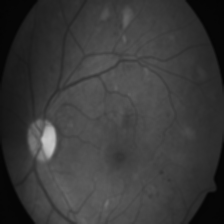

After noise reduction


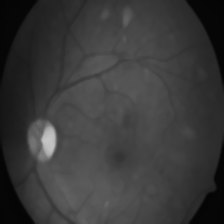

After gradient calculation


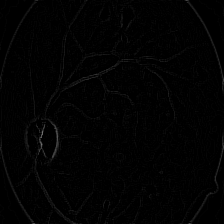

After thinning


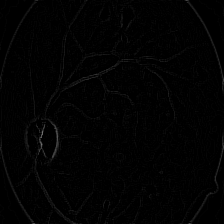

After thresholding


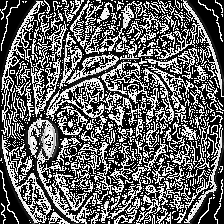

After linking


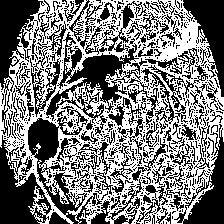

(224, 224)


In [106]:
random.seed(99)
indv = {
    "noise_reduction": {
        "method": "median",
        "params": {
            "ksize": (5, 5),
            "sigma": 1.5,
            "d": 5,
            "sigma_color": 75,
            "sigma_space": 75
        }
    },
    "gradient": {
        "method": "laplacian",
        "params": {
            "ksize": 3,
            "ddepth": 6,
            "do_laplacian": True
        }
    },
    "thinning": True,
    "thresholding": {
        "method": "hysteresis",
        "params": {
            "low": 90,
            "high": 170,
            "max_value": 255,
            "threshold_type": cv2.THRESH_BINARY
            # "threshold_type": np.random.choice([cv2.THRESH_BINARY, cv2.THRESH_BINARY_INV, cv2.THRESH_TRUNC, cv2.THRESH_TOZERO, cv2.THRESH_TOZERO_INV])
        }
    },
    "linking": {
        "method": "region_growing",
        "params": {
            "rho": 1,
            "theta": np.pi / 180,
            "threshold": 0.03,
            "seed_points": []
        }
    }
}

cv2_imshow(gray_images[5])
edges = apply_edge_detection_pipeline(gray_images[5], indv['noise_reduction'], indv['gradient'], indv['thinning'], indv['thresholding'], indv['linking'])
print(edges.shape)

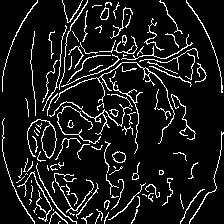

In [107]:
cv2_imshow(canny_ref_imgs[5])

After noise reduction


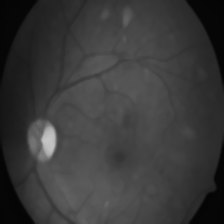

After gradient calculation


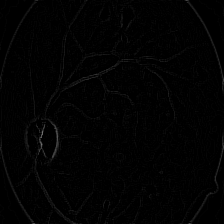

After thinning


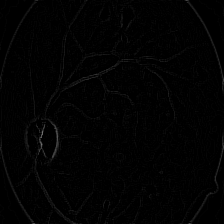

After thresholding


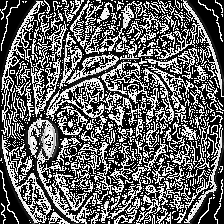

After linking


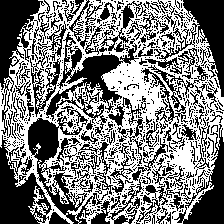

[2.9432229111393915,
 20910.52931680485,
 4.927153344367529,
 0.004873647338363384,
 0.75]

In [108]:
fitness_function(indv, gray_images[5])

In [109]:
# evaluate canny
calculate_metrics(gray_images[10], canny_ref_imgs[10])

(11936.136100924745,
 7.362165986998051,
 0.007518900694514651,
 0.46511627906976744)

## Run the program
We selected Image 5 as our general image which the GA will use to build a general configuration for our pipeline.

In [ ]:
# def calculate_metric(edges, reference_image):
#     # Calculate metrics
#     mse = mean_squared_error(reference_image, edges)
#     psnr = peak_signal_noise_ratio(reference_image, edges)
#     ssim = structural_similarity(reference_image, edges)

#     # SIFT feature extractor
#     sift = cv2.SIFT_create()
#     keypoints_1, descriptors_1 = sift.detectAndCompute(edges, None)
#     keypoints_2, descriptors_2 = sift.detectAndCompute(reference_image, None)

#     # Feature matching
#     bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)
#     matches = bf.match(descriptors_1, descriptors_2)
#     matches = sorted(matches, key=lambda x: x.distance)

#     # Calculate similarity score
#     num_good_matches = len(matches)
#     total_keypoints_1 = len(keypoints_1)
#     total_keypoints_2 = len(keypoints_2)
#     sift_sim_score = num_good_matches / max(total_keypoints_1, total_keypoints_2)

#     # Combine metrics to form a fitness score
#     fitness_score = (0.4 * mse) + 0.2 * (1 / psnr) + 0.2 * (1 / ssim) + 0.2 * (1 - sift_sim_score)
#     return fitness_score

# def build_noise_reduction_options():
#     # Gaussian method with different ksize and sigma values
#     noise_reduction_options = []
#     for ksize in [(3, 3), (5, 5), (7, 7)]:
#         for sigma in [0.5, 1.25]:
#             noise_reduction_options.append({'method': 'gaussian', 'params': {'ksize': ksize, 'sigma': sigma}})

#     # Median method with different ksize values
#     for ksize in [(3, 3), (5, 5), (7, 7)]:
#         noise_reduction_options.append({'method': 'median', 'params': {'ksize': ksize}})

#     # Bilateral method with different d, sigma_color, and sigma_space values
#     for d in [11, 13, 15]:
#         for sigma_color in [75, 100, 125]:
#             for sigma_space in [75, 100, 125]:
#                 noise_reduction_options.append({'method': 'bilateral', 'params': {'d': d, 'sigma_color': sigma_color, 'sigma_space': sigma_space}})
#     return noise_reduction_options

# def build_gradient_options():
#     gradient_options = []

#     for method in ['sobel', 'prewitt', 'laplacian']:
#         for ksize in [3, 5]:
#             gradient_options.append({'method': method, 'params': {'ksize': ksize}})
#     return gradient_options

# def build_threshold_options():
#     threshold_options = []

#     # Binary method with different low threshold values
#     for low, high in [(50, 100), (75, 150)]:
#         threshold_options.append({'method': 'binary', 'params': {'low': low}})

#     # Hysteresis method with different low and high threshold values
#     for low, high in [(50, 100), (75, 150)]:
#         threshold_options.append({'method': 'hysteresis', 'params': {'low': low, 'high': high}})
#     return threshold_options

# def build_linking_options():
#     linking_options = []

#     # Hough method with different threshold values
#     for threshold in [75, 125, 200]:
#         linking_options.append({'method': 'hough', 'params': {'threshold': threshold}})

#     # Region Growing method with different threshold values
#     for threshold in [75, 125, 200]:
#         linking_options.append({'method': 'region_growing', 'params': {'threshold': threshold, 'seed_points': []}})
#     return linking_options

In [ ]:
# from tqdm import tqdm

# def optimize_pipeline(image, reference_image):
#     best_params = {}
#     best_score = float('inf')

#     # Define ranges for parameters
#     noise_reduction_options = build_noise_reduction_options()
#     gradient_options = build_gradient_options()
#     threshold_options = build_threshold_options()
#     linking_options = build_linking_options()

#     # Calculate the total number of combinations
#     total_combinations = (len(noise_reduction_options) *
#                           len(gradient_options) *
#                           len(threshold_options) *
#                           len(linking_options))

#     # Create a progress bar
#     with tqdm(total=total_combinations, desc='Optimizing Pipeline') as pbar:
#         # Iterate over possible combinations
#         for noise_reduction in noise_reduction_options:
#             for gradient in gradient_options:
#                 for threshold in threshold_options:
#                     for linking in linking_options:
#                         # Apply pipeline with current parameters
#                         edges = apply_edge_detection_pipeline(image, noise_reduction, gradient, {}, threshold, linking)

#                         # Calculate metrics (e.g., MSE with reference image)
#                         score = calculate_metric(edges, reference_image)

#                         # Update best parameters
#                         if score < best_score:
#                             best_score = score
#                             best_params = {'noise_reduction': noise_reduction, 'gradient': gradient, 'threshold': threshold, 'linking': linking}

#                         # Update progress bar
#                         pbar.update(1)

#     return best_params, best_score

# # Run program
# best_params, best_score = optimize_pipeline(gray_images[5], canny_ref_imgs[5])
# print(best_params, best_score)

Optimizing Pipeline: 100%|██████████| 5184/5184 [52:19<00:00,  1.65it/s]

{'noise_reduction': {'method': 'gaussian', 'params': {'ksize': (3, 3), 'sigma': 0.5}}, 'gradient': {'method': 'sobel', 'params': {'ksize': 3}}, 'threshold': {'method': 'hysteresis', 'params': {'low': 50, 'high': 100}}, 'linking': {'method': 'region_growing', 'params': {'threshold': 75, 'seed_points': array([[  2, 108],
       [  3,  38],
       [  5, 129],
       ...,
       [221, 121],
       [221, 122],
       [222,  40]])}}} 5262.053767886916


In [ ]:
# define the parameter values
# pop_size = 200
# generations = 50
# cross_rate = 0.82
# mutation_rate = 0.125
# tournament_size = 5
# seed_value = 24029
# counter = 0
pop_size_range = [100, 125, 150, 200, 225, 250]
generations_range = [30, 40, 50]
cross_rate_range = [0.75, 0.8, 0.82, 0.85, 0.9]
mutation_rate_range = [0.05, 0.1, 0.125, 0.15, 0.2]
tournament_size_range = [3, 4, 5, 6, 7]
counter = 0

while True:
  print('Which Pipeline would you like to build?\n1) General Pipeline\n2) Individual Pipeline\n3) Exit Program')
  # choice = input('Your choice: ')
  choice = '1'
  if choice == '1':
    # build general pipeline using Image 5
    # seed_value = int(input('Seed Value: '))
    # pop_size = int(input('Population Size: '))
    # generations = int(input('Generations: '))
    # cross_rate = float(input('Crossover Rate: '))
    # mutation_rate = float(input('Mutation Rate: '))
    # tournament_size = int(input('Tournament Size: '))
    seed_value = random.randint(100, 10000)

    # set seed
    random.seed(seed_value)

    # randomly select param values
    pop_size = random.choice(pop_size_range)
    generations = random.choice(generations_range)
    cross_rate = random.choice(cross_rate_range)
    mutation_rate = random.choice(mutation_rate_range)
    tournament_size = random.choice(tournament_size_range)

    # run GA
    general_pipeline, best_fit, best_MSE, best_PSNR, best_SSIM, best_SIFT_SIM = run_GA(gray_images[5], canny_ref_imgs[5], pop_size, generations, cross_rate, mutation_rate, tournament_size)
    counter += 1
    # save scores and pipeline to a file
    with open(f'/content/drive/MyDrive/University/Honours/COS791/Assignments/A1/{counter}_general_pipeline.txt', 'w') as f:
      f.write(f'Seed Value: {seed_value}\n')
      f.write(f'Pop Size: {pop_size}\n')
      f.write(f'Generations: {generations}\n')
      f.write(f'Crossover Rate: {cross_rate}\n')
      f.write(f'Mutation Rate: {mutation_rate}\n')
      f.write(f'Tournament Size: {tournament_size}\n')
      f.write(f'Pipeline Configuration: {str(general_pipeline)}\n')
      f.write(f'Best Fitness: {round(best_fit,4)}\n')
      f.write(f'Best MSE: {round(best_MSE,4)}\n')
      f.write(f'Best PSNR: {round(best_PSNR,4)}\n')
      f.write(f'Best SSIM: {round(best_SSIM,4)}\n')
      f.write(f'Best SIFT Similarity: {round(best_SIFT_SIM,4)}\n')

  elif choice == '2':
    # build individual pipeline for all images
    pop_size = int(input('Population Size: '))
    generations = int(input('Generations: '))
    cross_rate = float(input('Crossover Rate: '))
    mutation_rate = float(input('Mutation Rate: '))
    tournament_size = int(input('Tournament Size: '))

    individual_pipelines = []
    for i in range(len(gray_images)):
      individual_pipelines.append(run_GA(gray_images[i], canny_ref_imgs[i], pop_size, generations, cross_rate, mutation_rate, tournament_size))

    for i in range(len(individual_pipelines)):
      print(f'Pipeline for Image {i}: ')
      print(individual_pipelines[i])

  elif choice == '3':
    print('Exited Program')
    break
  else:
    print('Invalid choice. Please try again.')

Which Pipeline would you like to build?
1) General Pipeline
2) Individual Pipeline
3) Exit Program
**************************************************
-----------------  Generation 0  ------------------
Before evaluating population: None
-----Evaluating Population: 100.0 %
After evaluating population: None
After evaluating population and assignment: 4383.49892650088
-----Old Best Fitness: None
-----New Best Fitness: 4383.49892650088
-----Best Pipeline Scores: 
Fitness: 4383.49892650088
MSE: 10957.158302774234
PSNR: 7.733824247345651
SSIM: 0.41542683305903794
SIFT Similarity: 0.3584379358437936
Before EVOLVING population: 4383.49892650088
-----Evolving Population: 100.0 %
After EVOLVING population: 4383.49892650088
**************************************************
**************************************************
-----------------  Generation 1  ------------------
Before evaluating population: 4383.49892650088
-----Evaluating Population: 100.0 %
After evaluating population: 4383.498926